In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import seaborn as sns
import csv
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', None)

## Download data from https://www.kaggle.com/c/avazu-ctr-prediction

In [2]:
data_frame = pd.read_csv('data/ad_data/train.csv', nrows=2000)

In [4]:
data_frame.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
3,10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
4,10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157


In [5]:
data_frame.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,2.000000e+03,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,9.411442e+18,0.164500,14102100.0,1005.027500,0.187000,1.052000,0.200500,17728.917500,318.412000,57.517000,1968.592000,0.813000,125.271000,39788.956500,87.492500
std,2.496207e+18,0.370821,0.0,1.051806,0.390009,0.565204,0.643045,3109.411542,9.509757,38.962492,383.160429,1.242499,230.786351,48999.551862,45.171597
min,1.004777e+16,0.000000,14102100.0,1001.000000,0.000000,0.000000,0.000000,377.000000,216.000000,36.000000,112.000000,0.000000,35.000000,-1.000000,13.000000
25%,1.005475e+19,0.000000,14102100.0,1005.000000,0.000000,1.000000,0.000000,15705.000000,320.000000,50.000000,1722.000000,0.000000,35.000000,-1.000000,61.000000
50%,1.013005e+19,0.000000,14102100.0,1005.000000,0.000000,1.000000,0.000000,17653.000000,320.000000,50.000000,1973.500000,0.000000,35.000000,-1.000000,79.000000
75%,1.020999e+19,0.000000,14102100.0,1005.000000,0.000000,1.000000,0.000000,20362.000000,320.000000,50.000000,2307.000000,2.000000,39.000000,100084.000000,117.000000
max,1.028688e+19,1.000000,14102100.0,1010.000000,1.000000,5.000000,5.000000,21704.000000,320.000000,480.000000,2497.000000,3.000000,1835.000000,100248.000000,157.000000


In [6]:
pd.get_dummies(data_frame['site_category'], prefix='site_category').head()

,site_category_0569f928,site_category_110ab22d,site_category_28905ebd,site_category_335d28a8,site_category_3e814130,site_category_50e219e0,site_category_72722551,site_category_75fa27f6,site_category_76b2941d,site_category_c0dd3be3,site_category_f028772b,site_category_f66779e6
0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# transform categorical data
exclude_from_transformation = ['id', 'click', 'hour', 'device_ip', 'device_id']
headers = data_frame.columns.tolist()
for header in headers:
    if header in exclude_from_transformation:
        continue
    one_hot = pd.get_dummies(data_frame[header], prefix=header)
    data_frame = data_frame.drop(header, axis=1)
    data_frame = data_frame.join(one_hot)

In [8]:
X = data_frame.drop(['click', 'id', 'hour', 'device_ip', 'device_id'], axis=1)
Y = data_frame['click']
print(X.shape)

(2000, 1363)


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/4., random_state=0)

In [11]:
lm = LinearRegression()
lm.fit(X_train, Y_train)

Y_train_pred = lm.predict(X_train)
Y_test_pred = lm.predict(X_test)

train_mse = sklearn.metrics.mean_squared_error(Y_train, Y_train_pred)
test_mse = sklearn.metrics.mean_squared_error(Y_test, Y_test_pred)
print("Train MSE {}".format(train_mse))
print("Test MSE {}".format(test_mse))

Train MSE 0.0683599993388
Test MSE 3.40921940717e+23


In [12]:
lm_ridge = Ridge(alpha=0.5)
lm_ridge.fit(X_train, Y_train)

Y_train_pred = lm_ridge.predict(X_train)
Y_test_pred = lm_ridge.predict(X_test)

train_mse = sklearn.metrics.mean_squared_error(Y_train, Y_train_pred)
test_mse = sklearn.metrics.mean_squared_error(Y_test, Y_test_pred)
print("Ridge Regression Train MSE {}".format(train_mse))
print("Ridge Regression Test MSE {}".format(test_mse))

Ridge Regression Train MSE 0.0695828067253
Ridge Regression Test MSE 0.166796628305


In [ ]:
# For Video 1.5
from sklearn.externals import joblib
joblib.dump(lm_ridge, 'models/ad_model.pkl') 
#

In [13]:
np.sum(lm.coef_)/np.sum(lm_ridge.coef_)

1.2497235127130489e+25

# 

[ 0.1         0.64444444  1.18888889  1.73333333  2.27777778  2.82222222
  3.36666667  3.91111111  4.45555556  5.        ]


<IPython.core.display.Javascript object>


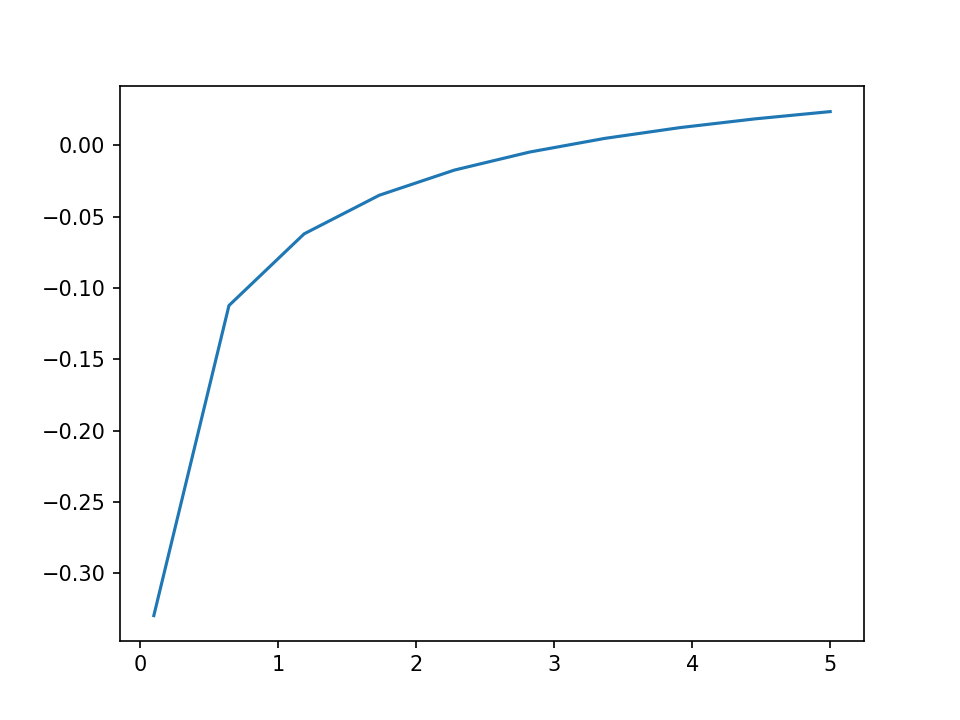

In [14]:
lm_ridge = Ridge()
alphas = np.linspace(0.1, 5, 10)
print(alphas)
n_folds = 3

clf = GridSearchCV(lm_ridge, [{'alpha': alphas}], cv=n_folds)
clf.fit(X_train, Y_train)
scores = clf.cv_results_['mean_test_score']
plt.plot(alphas, scores)